In [1]:
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
import pandas as pd
from tqdm import tqdm
from IPython.display import display

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow.keras import initializers
from functools import partial
%load_ext autoreload
%autoreload 2
sns.set(style="whitegrid", font_scale=2.25)
# plt.rcParams.update({"text.usetex": True})
import sys, os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
try: #If running in colab
    import google.colab
    IN_COLAB = True
    %tensorflow_version 2.x
    #upload vimlts.py first
    !wget https://raw.githubusercontent.com/stefan1893/TM-VI/main/src/vimlts_fast.py
    sys.path.append(".")
    from vimlts_fast import VimltsLinear, ConjungateDenseViGauss
except:
    IN_COLAB = False
    sys.path.append('../')
    from src.vimlts_fast import VimltsLinear, ConjungateDenseViGauss

print(tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print('Tensorflow version: ',tf.__version__, )


[]
Num GPUs Available:  0
Tensorflow version:  2.6.2


2021-12-07 13:19:59.917195: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-12-07 13:19:59.917238: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: ios-vm
2021-12-07 13:19:59.917248: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: ios-vm
2021-12-07 13:19:59.917326: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.57.2
2021-12-07 13:19:59.917349: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.57.2
2021-12-07 13:19:59.917355: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.57.2
2021-12-07 13:19:59.917612: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in perf

We define the prior as a Beta distribution and the coresponding likelihood
is the Bernoulli distribution -> Posterior is a Beta-distribution too.

Likelihood: $$y \thicksim Bernoulli(\pi)$$

Prior: $$ \pi \thicksim  Beta(\alpha, \beta) $$

Posterior: $$p(\pi | y) = \frac{p(y| \pi) \cdot p(\pi)}{p(y)}$$

==> In this case the posterior is known because of the conjugate prior

==> Posterior is a Beta distribution too. Parameters:

$$p(\pi|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$


Prior:
$p(\pi) \thicksim Beta(\alpha=0.5, \beta=5.)$

Text(0.5, 1.0, 'Prior p($\\pi$)')

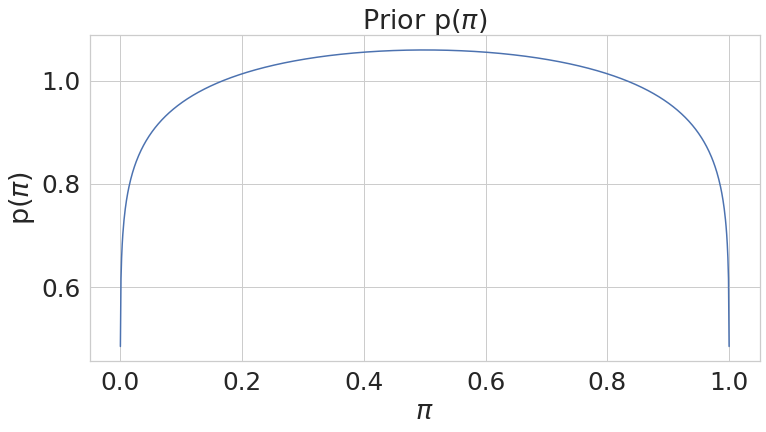

In [2]:
pis = np.linspace(0.0001, .9999, 1000)
alpha = 1.1
beta = 1.1
pdf_prior = stats.beta(a=alpha, b=beta).pdf(x=pis)
plt.figure(figsize=(12,6))
sns.lineplot(data=pd.DataFrame.from_dict({'p($\pi$)':pdf_prior, '$\pi$':pis}), x='$\pi$', y='p($\pi$)')
plt.title("Prior p($\pi$)")

Likelihood

(array([0., 0., 0., 0., 0., 2., 0., 0., 0., 0.]),
 array([0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3, 1.4, 1.5]),
 <BarContainer object of 10 artists>)

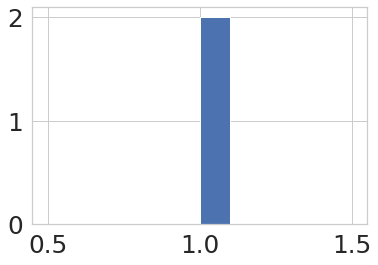

In [3]:
# np.random.seed(3)
# data = stats.bernoulli(p=0.5).rvs(size=2)
data = np.ones((2))
ytensor = data.reshape(-1, 1)
plt.hist(data)

Text(0.5, 1.0, 'Likelihood p(y|$\\pi$)')

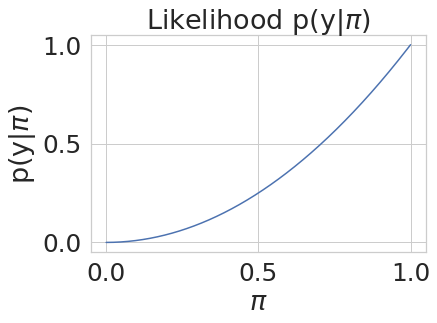

In [4]:
log_likelihood = [stats.bernoulli(p=pi).logpmf(data).sum() for pi in pis]
likelihood = np.exp(log_likelihood)
sns.lineplot(data=pd.DataFrame.from_dict({'p(y|$\pi$)':likelihood, '$\pi$':pis}), x='$\pi$', y='p(y|$\pi$)')
plt.title("Likelihood p(y|$\pi$)")

Posterior analytic

$$p(\pi|y) \thicksim Beta(\alpha + \sum{x_i}, \beta+n-\sum{x_i})$$

integral of pdf:  0.999786146673809


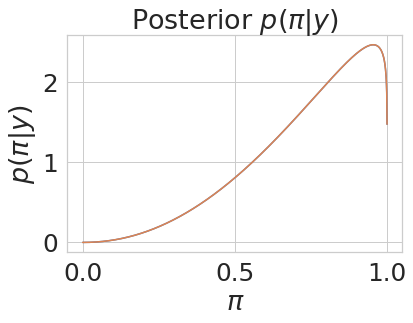

In [5]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=pis)
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':pdf_post, '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$')
plt.plot(pis, likelihood*pdf_prior/np.trapz(likelihood*pdf_prior, pis), linestyle='solid')
plt.title("Posterior $p(\pi|y)$")
print("integral of pdf: ", np.trapz(pdf_post, pis))

like * prior same as analytic known posterior distribution

Now use VIMLTs to approximate posterior distribution


## TM-VI vs Gauss-VI


In [6]:
def scheduler(epoch, lr, lr_start, lr_stop, epochs):
    return lr_start + (lr_stop-lr_start)*(epoch/epochs)

@tf.function
def sample_bernoulli_nll(y_obs, y_pred):
    """
    Args:
        y_obs: true labels. Expected shape (#batch, 1) or (#batch)
        y_pred: model prediction. Expected shape (#samples, #batch, 1) or (#samples, #batch)

    Returns: sum of Nll
    """
    if len(y_pred.shape) == 2:  # Bug tf?! If we have a single output it squeezes y_pred. I did not want this behaviour.
        y_pred = y_pred[...,None]
    tf.debugging.check_numerics(y_pred, "Prediction for nll computation contains NaNs or Infs")
    error_str = f"Expected one of the above defined shapes. Got shapes: y_obs: {y_obs.shape}; y_pred: {y_pred.shape}"
    assert y_pred.shape[-1] == y_obs.shape[-1] or ((len(y_pred.shape) == 3) and y_pred.shape[-1] == 1), error_str

    dist = tfp.distributions.Bernoulli(probs=y_pred)
    nll_per_sample = -dist.log_prob(y_obs)
    nlls = tf.reduce_mean(nll_per_sample, axis=0)
    tf.debugging.check_numerics(nlls, "NLL contains NaNs or Infs")
    return tf.reduce_sum(nlls)
    # return 0.

def softplus_inv(y):
    return np.log(np.exp(y) - 1)

### initialize TM-VI

In [65]:
models = {}
Ms = [1,3,10,30,100,]
Ms = [10,]
theta_start = -10
theta_stop = 10
for M in Ms:
    # init params
    # kernel_initializers=dict(kernel_init_alpha_w = initializers.RandomNormal(mean=1.5),
    #                          kernel_init_beta_w = initializers.RandomNormal(),
    #                          kernel_init_alpha_z = initializers.RandomNormal(mean=1),
    #                          kernel_init_beta_z = initializers.RandomNormal(),
    #                          kernel_init_thetas = [initializers.RandomNormal(mean=-1.5, stddev=.3)] + [initializers.RandomNormal(mean=softplus_inv((2+1.5)/M), stddev=.5) for i in range(M)])
    # kernel_initializers=dict(kernel_init_thetas = [initializers.RandomNormal(mean=-1.5, stddev=.3)] + [initializers.RandomNormal(mean=softplus_inv((2+1.5)/M), stddev=.5) for i in range(M)])
    kernel_initializers=dict(kernel_init_thetas = [initializers.Constant(theta_start)] + [initializers.Constant(softplus_inv((theta_stop-theta_start)/(M))) for i in range(M)])

    # define model
    tf.random.set_seed(2)
    layer = VimltsLinear(1,
                         activation=tfp.bijectors.Sigmoid(low=1e-6, high=1.-1e-6),
                         **kernel_initializers,
                         num_samples=10000,
                         prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta),
                         # base_dist = tfd.Uniform(low=0.00001, high=1.-1e-9),
                         base_dist = tfd.Beta(1.4, 1.4),
                         input_shape=(1,),)
    model = tf.keras.Sequential([layer], name=f"TM-VI-degree{M}")
    model.build(input_shape=(None, 1))
    models[f"TM-VI M={M}"] = model
model.summary()

Model: "TM-VI-degree10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vimlts_linear_17 (VimltsLine (10000, None, 1)          15        
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________


### initialize VI Gauss implementation

In [66]:
tf.random.set_seed(2)
vi_gauss_l = ConjungateDenseViGauss(1,
                                   activation=tfp.bijectors.Sigmoid(low=1e-6, high=1.-1e-6),
                                   num_samples=10000,
                                   kernel_init_mu_w = initializers.Constant(0.),
                                   kernel_init_rhosigma_w = initializers.Constant(0.2),
                                   prior_dist=tfd.Beta(concentration1=alpha, concentration0=beta))
vi_gauss = tf.keras.Sequential([vi_gauss_l], name="Gauss-VI")
vi_gauss.build(input_shape=(None,1))
vi_gauss.summary()
models["Gauss-VI"] = vi_gauss

Model: "Gauss-VI"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conjungate_dense_vi_gauss_11 (10000, None, 1)          2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


### show initial distribution

VI Gaus with: N(<tf.Variable 'conjungate_dense_vi_gauss_11/kernel_mu:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,[[0.79813886]])


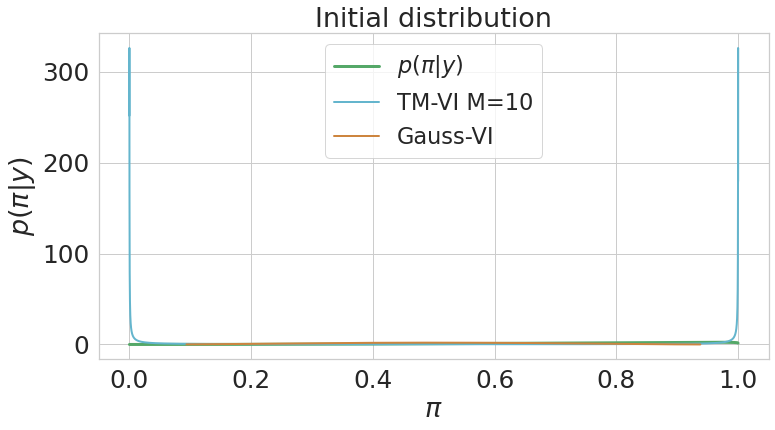

In [67]:
plt.figure(figsize=(12,6))
pdf_post = stats.beta(a=alpha_post, b=beta_post).pdf(x=pis)
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':pdf_post, '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$', label='$p(\pi|y)$', linewidth=3, color='g')
linestyles = ['-', ':', '--', '-.',]
ls = 0
for name, model in models.items():
    layer = model.layers[0]
    pi, log_q_pi = layer.sample(num=1000, bijector=tfp.bijectors.Sigmoid())
    pi = pi.numpy().squeeze()
    sort = np.argsort(pi)
    pi = pi[sort]
    log_q_pi = log_q_pi.numpy().squeeze()[sort]
    q_pi = tf.math.exp(log_q_pi)
    if "TM-VI" in name:
        plt.plot(pi, q_pi, label=name, linewidth=2., color='c', linestyle=linestyles[ls%4])
        ls += 1
    else:
        plt.plot(pi, q_pi, label=name, linewidth=2., color='peru')
plt.legend(fontsize='small')
plt.title("Initial distribution")
plt.savefig("00_initial_variational_distribution_VIMLTS.png")


### train

In [ ]:
class LogKL(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['epochs'] = epoch
        # kl = [layer.losses[0] for layer in self.model.layers]
        # # logs['kl'] = tf.reduce_sum(kl)
        # logs['kl'] = kl

for name, model in models.items():
    print(f"Start experiment with model {name}")
    epochs = 1000
    # epochs = 100
    # lr_callback = tf.keras.callbacks.LearningRateScheduler(partial(scheduler, lr_start=0.1, lr_stop=0.025, epochs=epochs))
    model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), loss=sample_bernoulli_nll, run_eagerly=False)
    model.fit(tf.ones((len(data),1)), ytensor, epochs=epochs, verbose=False, callbacks=[LogKL()])

Start experiment with model TM-VI M=10
Start experiment with model Gauss-VI


### Show posterior distribution of VIMLT and VI Gaussian and compute KL-Divergence
#### Table shows the KL-Divergence $D_{KL} (q_w(\pi) || p(\pi|D)$

In [ ]:
alpha_post = alpha + np.sum(data)
beta_post = beta + len(data) - np.sum(data)
post_analytic = tfd.Beta(alpha_post.astype(np.float32), beta_post.astype(np.float32))
plt.figure(figsize=(13,6))
sns.lineplot(data=pd.DataFrame.from_dict({'$p(\pi|y)$':post_analytic.prob(pis), '$\pi$':pis}), x='$\pi$', y='$p(\pi|y)$', label="Analytical posterior", linewidth=8, color='g', linestyle=(0, (1, 1.5)))
KLs = {}
KLs2 = {}
linestyles = [(0, (2, 2)), (0, (1, 1)), '-']
ls = 0
for name, model in models.items():
    layer = model.layers[0]
    pi, log_q_pi = layer.sample(num=100000, bijector=tfp.bijectors.Sigmoid())
    pi = pi.numpy().squeeze()
    sort = np.argsort(pi)
    pi=pi[sort]
    log_q_pi = log_q_pi.numpy().squeeze()[sort]
    q_pi = tf.math.exp(log_q_pi)

    # compute KL div KL(q(pi) || p(pi|D))
    log_p_pi_D = post_analytic.log_prob(pi)
    KLs[name] = np.mean(log_q_pi - log_p_pi_D)
    # or
    rel_entropy = q_pi * (log_q_pi - log_p_pi_D)
    kl_div = np.trapz(rel_entropy, x=pi)
    KLs2[name] = kl_div

    if "TM-VI" in name:
        plt.plot(pi, q_pi, label=name+f"; KL={kl_div:.2e}", linewidth=3., color='c', linestyle=linestyles[ls%3], alpha=0.8)
        ls += 1
    else:
        plt.plot(pi, q_pi, label=name+f"; KL={kl_div:.2e}", linewidth=3., color='peru', alpha=0.8)

plt.legend(fontsize='small')
# plt.title("Posterior distribution")
plt.tight_layout()
plt.savefig("00_conj_posterior.pdf")

print("Table shows the KL divergence KL(q(pi)||p(pi|D))")
display(pd.DataFrame.from_dict(KLs, orient='index', columns=["KL"]).sort_values('KL', ascending=False))
display(pd.DataFrame.from_dict(KLs2, orient='index', columns=["KL_nummeric"]).sort_values('KL_nummeric', ascending=False))


### Show loss curve

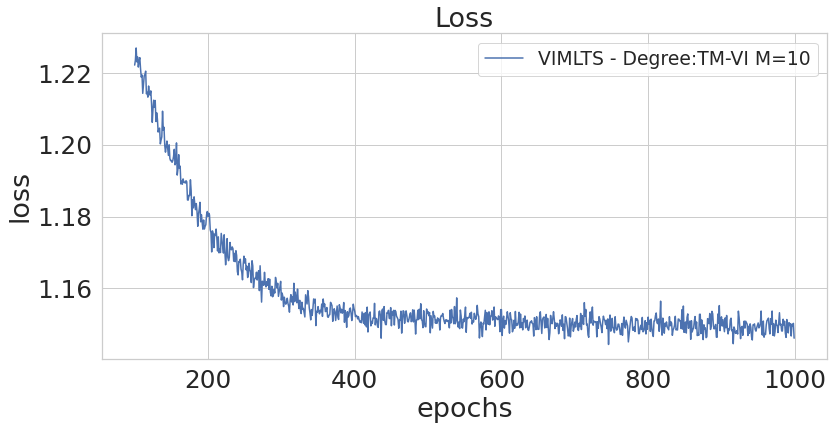

In [11]:
plt.figure(figsize=(13,6))
for m, model in models.items():
    plt.plot(model.history.history['epochs'][100:], model.history.history['loss'][100:], label=f"VIMLTS - Degree:{m}")
plt.title("Loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(fontsize='x-small')
plt.savefig("00_conj_prior_loss.png")

### Analyse init parameters

In [12]:
thetas = dict()
for M in range(2,15,4):
    delta_start = -6
    def softplus_inv(y):
        return np.log(np.exp(y) - 1)
    delta_theta_init = (delta_start,) + tuple(softplus_inv((2-delta_start)/(M-1)) for _ in range(M-1))

    theta_p = tf.cast(tf.reshape(delta_theta_init, (1,-1)), tf.float32) # [#input x #output x M]
    theta_p = tf.concat((theta_p[..., 0:1], tf.math.softplus(theta_p[..., 1:])), axis=-1)
    n = theta_p.shape[-1]
    # tf.ones((n * (n + 1) // 2))
    m_triangle = tfp.math.fill_triangular(tf.ones(n * (n + 1) // 2), upper=True)
    theta = theta_p @ m_triangle

    thetas[f"theta_degree{M}"] = [delta_theta_init, theta.numpy().squeeze()]

Text(0.5, 0, 'i')

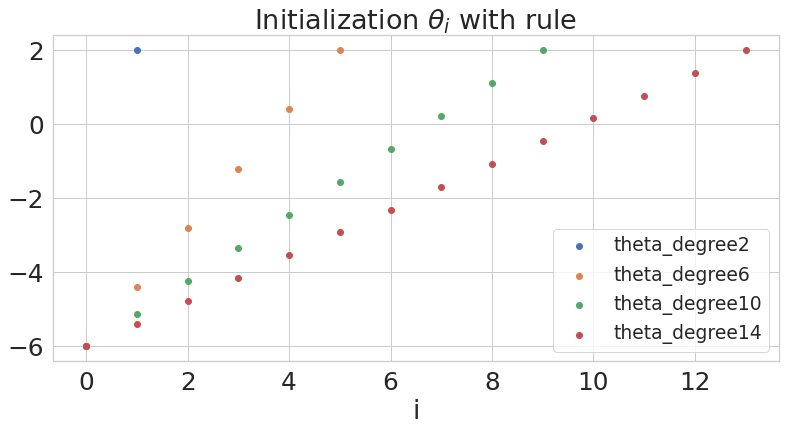

In [14]:
plt.figure(figsize=(13,6))
for name, (delta_theta, theta) in thetas.items():
    plt.scatter(range(len(theta)), theta, label=name)
plt.legend(fontsize='x-small')
plt.title("Initialization $\\theta_i$ with rule")
plt.xlabel("i")

Text(0.5, 0, 'i')

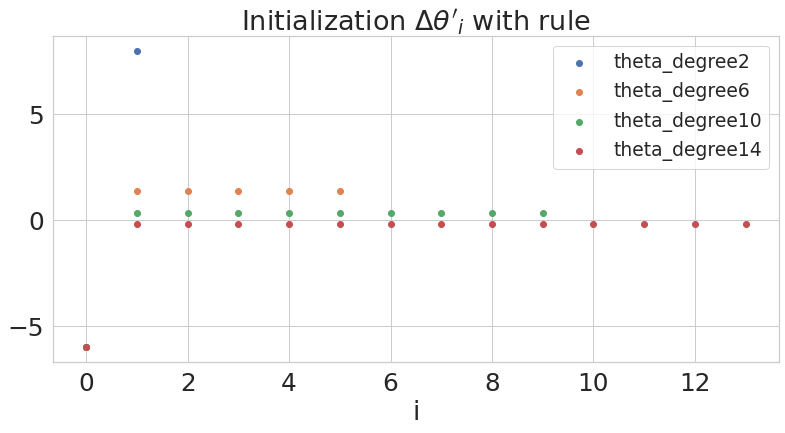

In [15]:
plt.figure(figsize=(13,6))
for name, (delta_theta, theta) in thetas.items():
    plt.scatter(range(len(delta_theta)), delta_theta, label=name)
plt.legend(fontsize='x-small')
plt.title("Initialization $\Delta\\theta'_i$ with rule")
plt.xlabel("i")



### Analyze results

In [3]:
df = pd.read_csv("../src/00_conj_prior_kl_eval_kl_1310.csv")
df.pop('Unnamed: 0')
df.set_index("seed", inplace=True)
cn_sort = df.mean().sort_values(ascending=False).index.to_list()
df = df[cn_sort]
df.reset_index(inplace=True)
df

,seed,Gauss-VI,TM-VI M=1,TM-VI M=2,TM-VI M=3,TM-VI M=4,TM-VI M=5,TM-VI M=9,TM-VI M=8,TM-VI M=7,TM-VI M=10,TM-VI M=30,TM-VI M=6,TM-VI M=300,TM-VI M=15,TM-VI M=100
0,2,0.021802,0.007906,0.010287,0.005260,0.004164,0.001075,0.000693,0.002516,0.002314,0.001072,0.001170,0.001505,0.000880,0.000440,0.002014
1,4,0.022562,0.006046,0.007821,0.006248,0.001275,0.000779,0.000862,0.001848,0.000885,0.001172,0.001295,0.000858,0.001150,0.000808,0.000755
2,6,0.022698,0.008986,0.006375,0.007940,0.002980,0.001749,0.001117,0.003276,0.001242,0.000420,0.000338,0.000847,0.001156,0.001005,0.001183
3,8,0.022751,0.007345,0.006713,0.005173,0.005078,0.000898,0.003507,0.001344,0.000859,0.002988,0.000417,0.000657,0.002113,0.000735,0.000155
4,10,0.022603,0.007474,0.006770,0.008109,0.006365,0.002025,0.002507,0.002162,0.001522,0.002011,0.001237,0.000603,0.000308,0.000406,0.000676
5,12,0.021893,0.008007,0.006030,0.007943,0.005156,0.003698,0.004712,0.001013,0.000623,0.000711,0.002400,0.001256,0.000205,0.000400,0.000881
6,14,0.021170,0.007442,0.007286,0.006275,0.003000,0.005913,0.001046,0.002959,0.001832,0.001665,0.000267,0.000817,0.000108,0.002372,0.000349
7,16,0.021558,0.008007,0.009142,0.006776,0.004004,0.001471,0.001361,0.000807,0.001557,0.001019,0.000649,0.001312,0.000807,0.002559,0.000523
8,18,0.022117,0.007290,0.007022,0.008761,0.003266,0.002540,0.001857,0.000642,0.000754,0.000374,0.000885,0.000544,0.003941,0.001047,0.000349
9,20,0.021782,0.007092,0.005913,0.005962,0.004435,0.002721,0.005258,0.000580,0.000909,0.000530,0.000987,0.000926,0.000117,0.002041,0.000604


,seed,"$log(KL(q(\pi), p(\pi|D))$"
Method,,
Gauss-VI,31.0,-3.808520
TM-VI M=1,31.0,-4.900941
TM-VI M=10,31.0,-6.939841
TM-VI M=100,31.0,-7.501151
TM-VI M=15,31.0,-7.114668
TM-VI M=2,31.0,-4.948855
TM-VI M=3,31.0,-5.088372
TM-VI M=30,31.0,-7.005381
TM-VI M=300,31.0,-7.235017


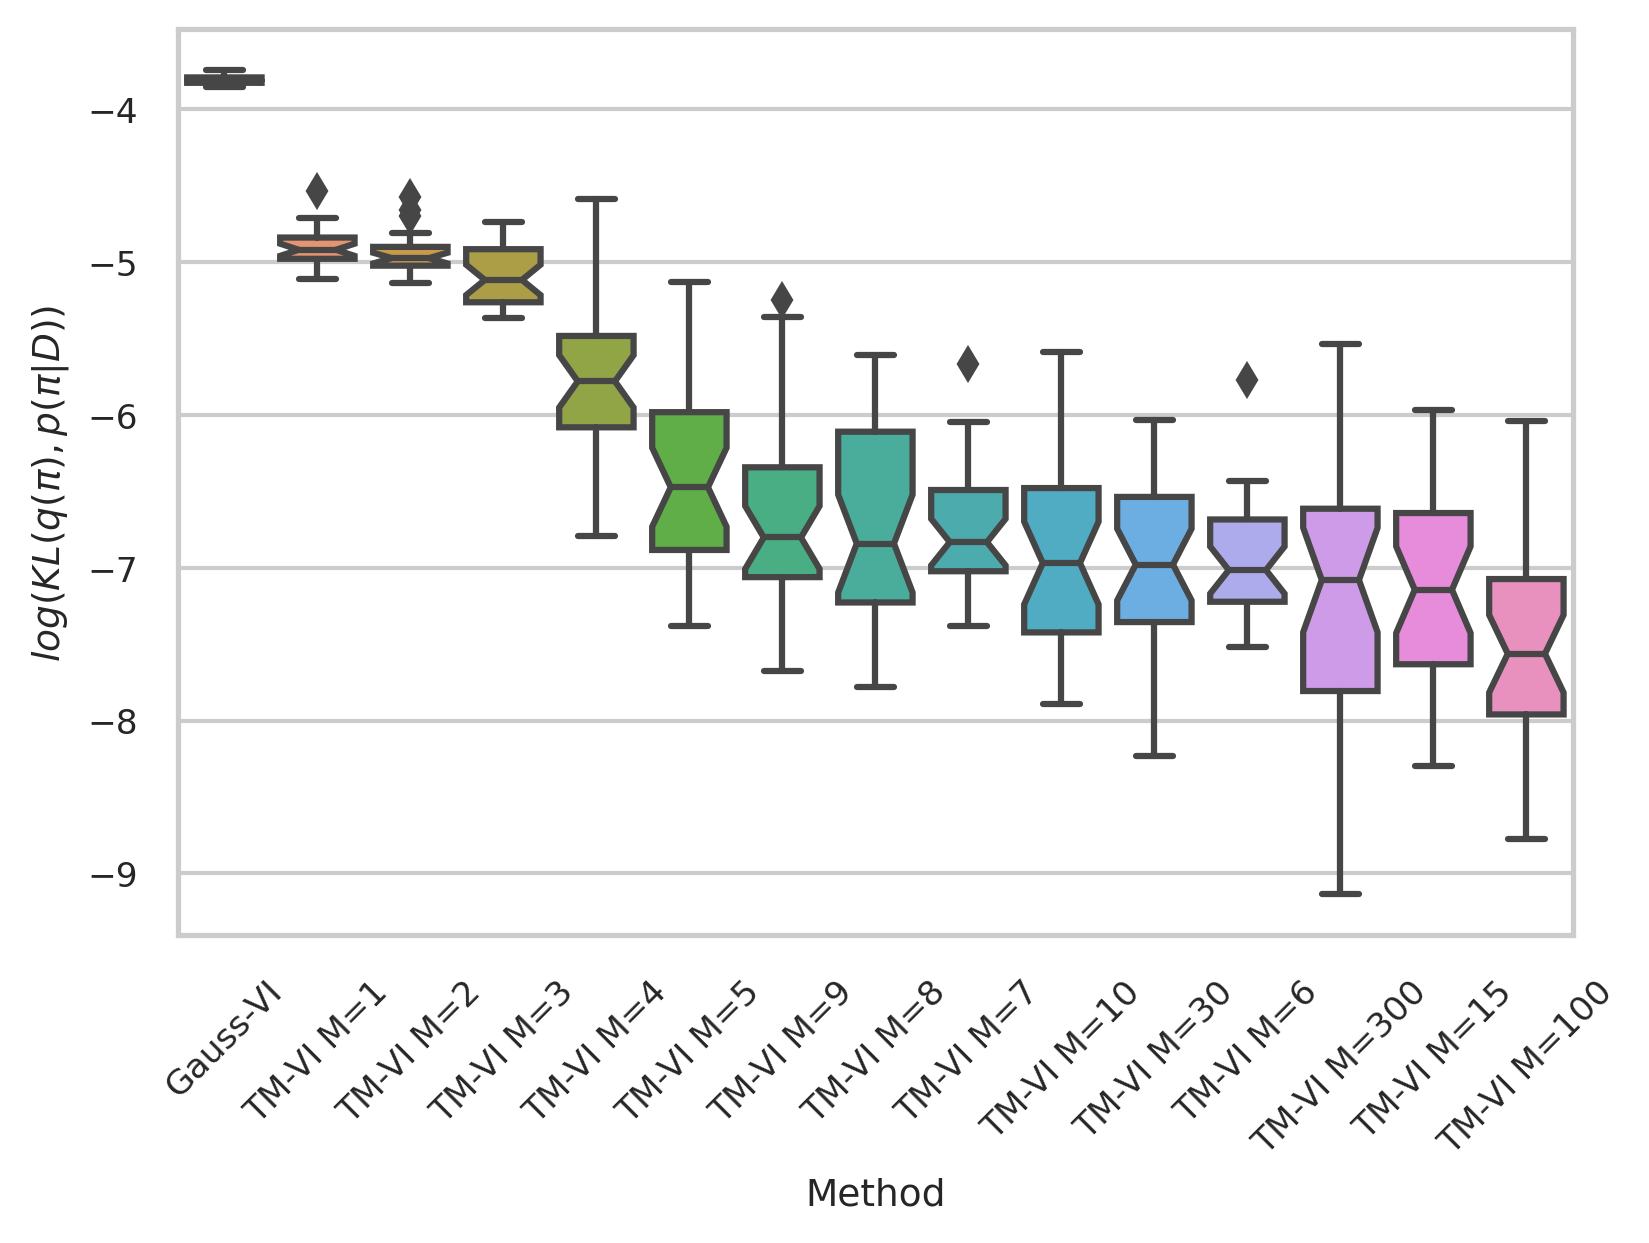

In [4]:
plt.rcParams['figure.dpi'] = 300
sns.set(style="whitegrid", font_scale=.75)
dfm = df.melt('seed', value_name="KL", var_name='Method')
dfm['$log(KL(q(\pi), p(\pi|D))$'] = dfm['KL'].apply(np.log)
dfm.pop('KL')
sns.boxplot(data=dfm, y='$log(KL(q(\pi), p(\pi|D))$', x="Method", notch=True)
plt.xticks(rotation=45)
dfm.groupby('Method').mean()

,seed,"$log(KL(q(\pi), p(\pi|D))$"
Method,,
Gauss-VI,21.0,-3.803745
TM-VI M=1,21.0,-4.895748
TM-VI M=10,21.0,-6.750609
TM-VI M=15,21.0,-6.955119
TM-VI M=2,21.0,-4.953698
TM-VI M=3,21.0,-5.127844
TM-VI M=30,21.0,-7.100124
TM-VI M=4,21.0,-5.942282
TM-VI M=5,21.0,-6.551085


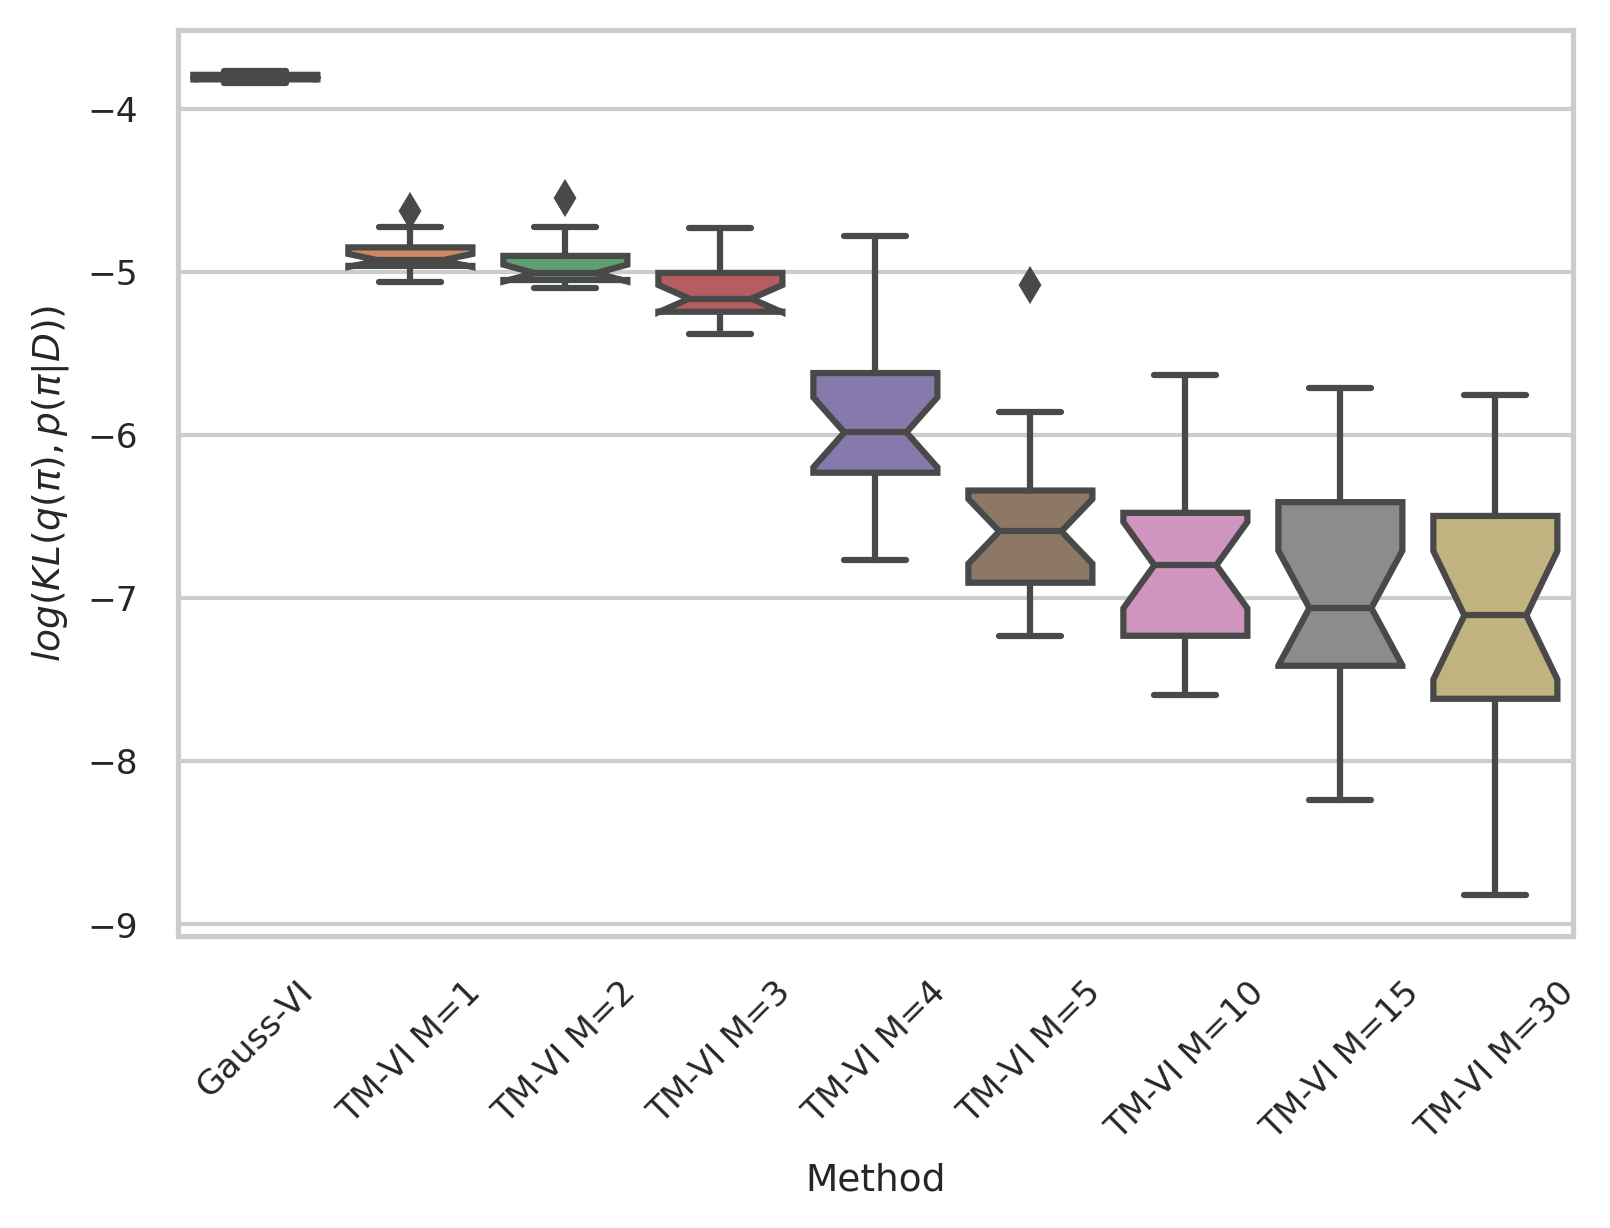

In [12]:
plt.rcParams['figure.dpi'] = 300
sns.set(style="whitegrid", font_scale=.75)
dfm = df.melt('seed', value_name="KL", var_name='Method')
dfm['$log(KL(q(\pi), p(\pi|D))$'] = dfm['KL'].apply(np.log)
dfm.pop('KL')
sns.boxplot(data=dfm, y='$log(KL(q(\pi), p(\pi|D))$', x="Method", notch=True)
plt.xticks(rotation=45)
dfm.groupby('Method').mean()

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 [Text(0, 0, 'Gauss-VI'),
  Text(1, 0, 'TM-VI M=1'),
  Text(2, 0, 'TM-VI M=2'),
  Text(3, 0, 'TM-VI M=3'),
  Text(4, 0, 'TM-VI M=4'),
  Text(5, 0, 'TM-VI M=5'),
  Text(6, 0, 'TM-VI M=10'),
  Text(7, 0, 'TM-VI M=15'),
  Text(8, 0, 'TM-VI M=30')])

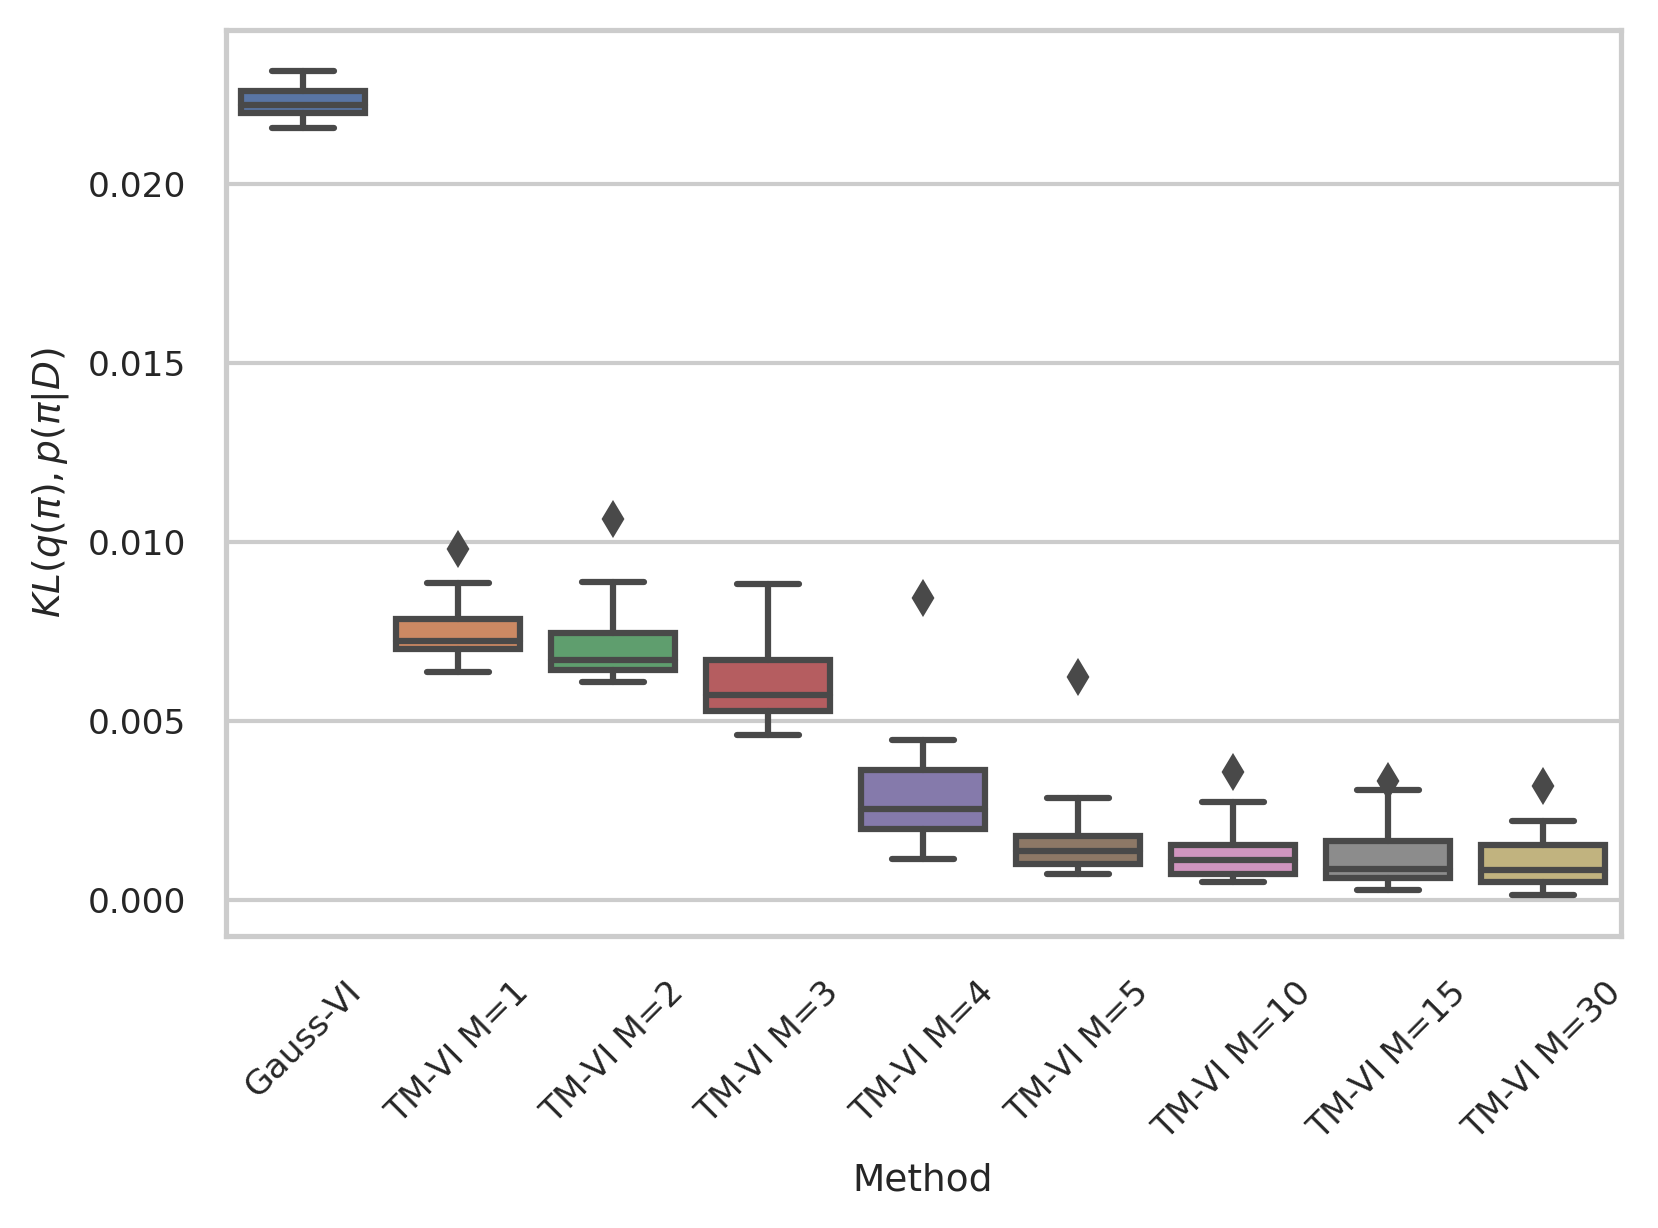

In [3]:
plt.rcParams['figure.dpi'] = 300
sns.set(style="whitegrid", font_scale=.75)
dfm = df.melt('seed', value_name="$KL(q(\pi), p(\pi|D)$", var_name='Method')
sns.boxplot(data=dfm, y='$KL(q(\pi), p(\pi|D)$', x="Method")
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 [Text(0, 0, 'Gauss-VI'),
  Text(1, 0, 'TM-VI M=2'),
  Text(2, 0, 'TM-VI M=1'),
  Text(3, 0, 'TM-VI M=3'),
  Text(4, 0, 'TM-VI M=4'),
  Text(5, 0, 'TM-VI M=5'),
  Text(6, 0, 'TM-VI M=7'),
  Text(7, 0, 'TM-VI M=8'),
  Text(8, 0, 'TM-VI M=6'),
  Text(9, 0, 'TM-VI M=9'),
  Text(10, 0, 'TM-VI M=15'),
  Text(11, 0, 'TM-VI M=10'),
  Text(12, 0, 'TM-VI M=30'),
  Text(13, 0, 'TM-VI M=100'),
  Text(14, 0, 'TM-VI M=300')])

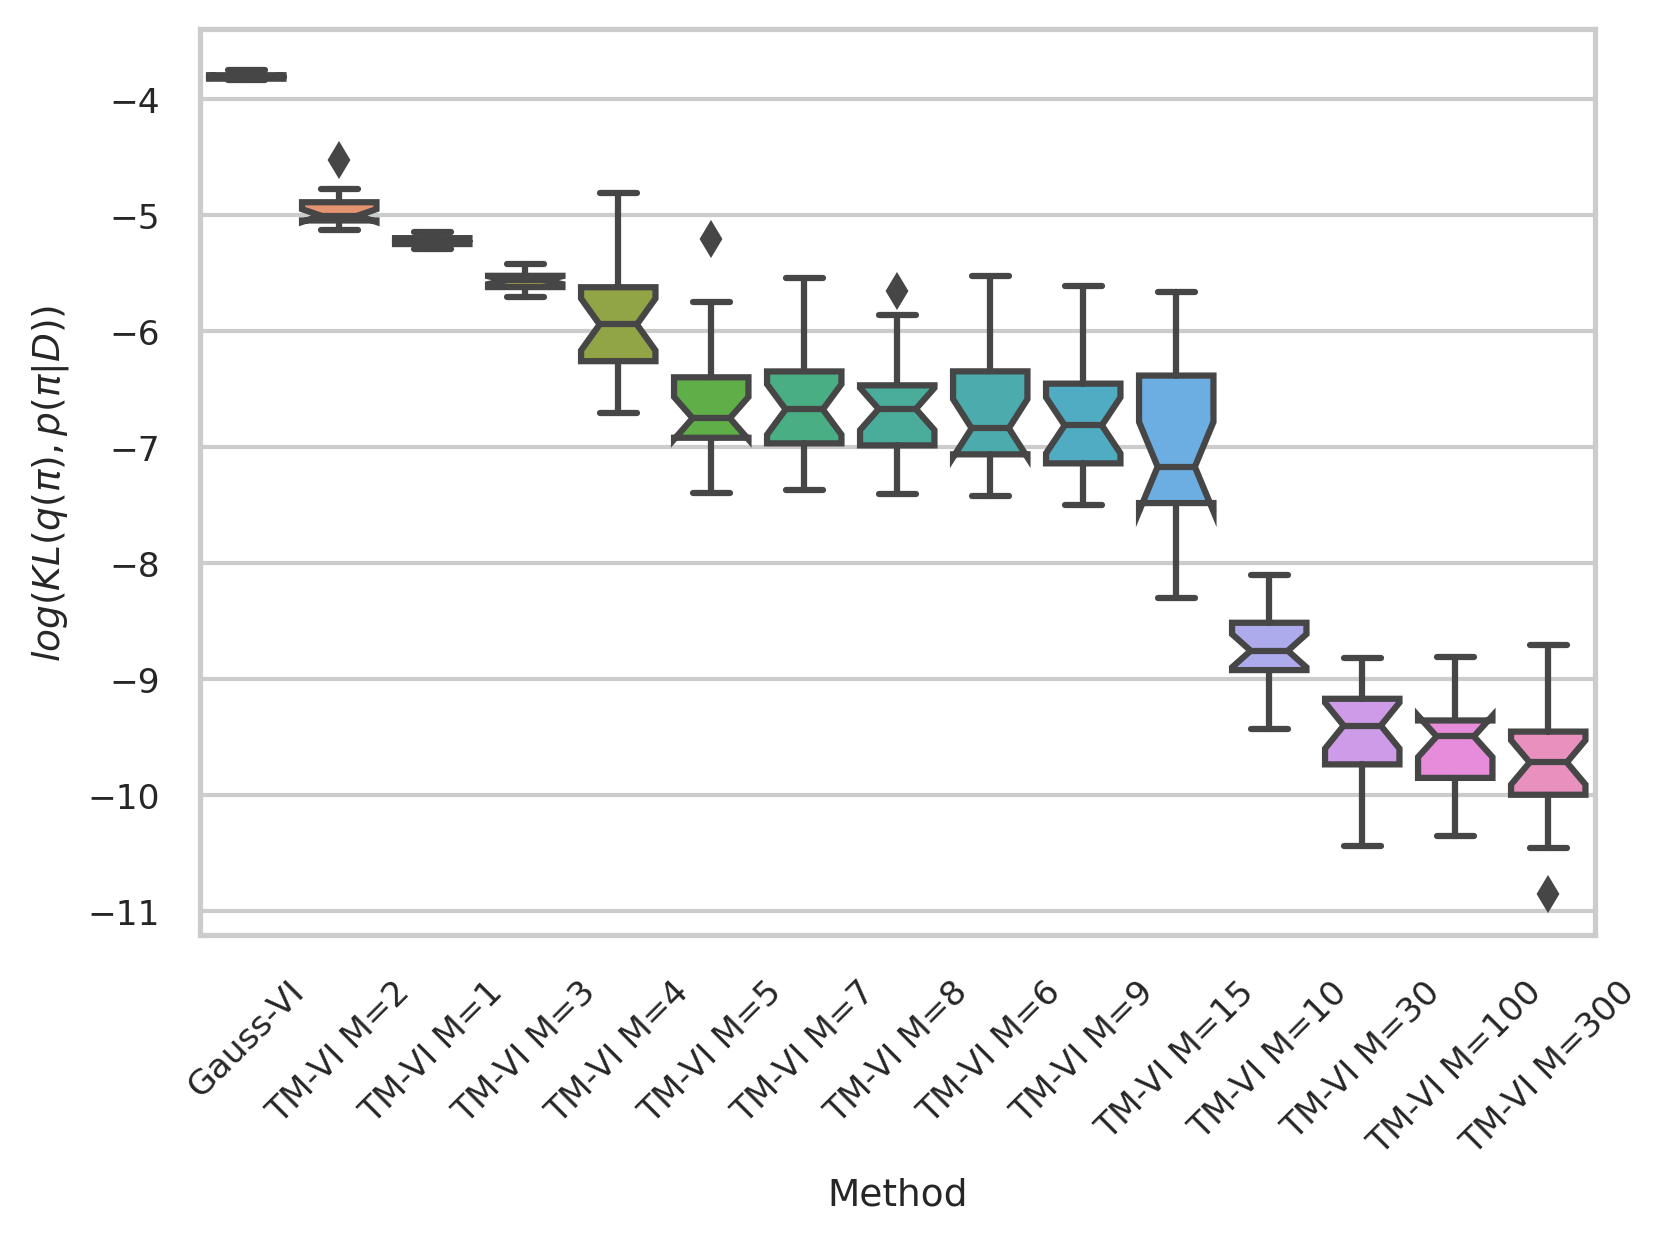

In [42]:
plt.rcParams['figure.dpi'] = 300
sns.set(style="whitegrid", font_scale=.75)
dfm = df.melt('seed', value_name="KL", var_name='Method')
dfm['$log(KL(q(\pi), p(\pi|D))$'] = dfm['KL'].apply(np.log)
dfm.pop('KL')
sns.boxplot(data=dfm, y='$log(KL(q(\pi), p(\pi|D))$', x="Method", notch=True)
plt.xticks(rotation=45)

In [47]:
base_kl = dfm.groupby("Method").mean().loc['TM-VI M=2', '$KL(q(\pi), p(\pi|D)$']
Ms = np.array([2, 4, 5, 6, 7, 8, 9, 15])
Msd = Ms/2
sns.lineplot(data=dfm, y='$KL(q(\pi), p(\pi|D)$', x="Method")
plt.plot(base_kl/Msd)
plt.xticks(rotation=45)

In [15]:
sns.lineplot(data=dfm, )
dfm.groupby("Method").mean()

,seed,KL
Method,,
Gauss-VI,21.0,0.022292
TM-VI M=15,21.0,0.001184
TM-VI M=2,21.0,0.007153
TM-VI M=4,21.0,0.002905
TM-VI M=5,21.0,0.001627
TM-VI M=6,21.0,0.001441
TM-VI M=7,21.0,0.001518
TM-VI M=8,21.0,0.001447
TM-VI M=9,21.0,0.001357


In [99]:
with np.load("../src/00_conj_prior_kl_eval_samples.npz", 'r', allow_pickle=True) as data:
    samples = data['samples'][()]
    seeds = list(samples.keys())
    Methods = samples[seeds[0]].keys()
    print("load seeds: ", seeds)
    print("load Methods: ", Methods)
    # print(samples)

load seeds:  [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40]
load Methods:  dict_keys(['TM-VI M=2', 'TM-VI M=4', 'TM-VI M=5', 'TM-VI M=6', 'TM-VI M=7', 'TM-VI M=8', 'TM-VI M=9', 'TM-VI M=15', 'Gauss-VI'])


In [24]:
from tensorflow_probability import distributions as tfd
shape = (10,)
tfd.TruncatedNormal(loc=tf.ones(shape)*0.5, scale=0.15, low=0., high=1.)

NotImplementedError: covariance is not implemented: TruncatedNormal

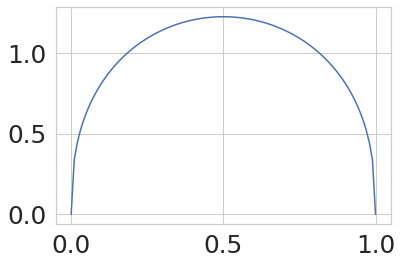

In [64]:
x = np.linspace(0,1,100)
pdf = tfd.Beta(1.4, 1.4).prob(x)
plt.plot(x, pdf)